In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import nussl
from utils import viz, data
import yaml
import os

In [8]:
from models.MaskInference import MaskInference
nussl.ml.register_module(MaskInference)

In [6]:
os.listdir('models/')

['.ipynb_checkpoints',
 'ST_mask_10_256_32hop',
 'ST_mask_10_256_0.3dropout',
 'test_auto',
 '__pycache__',
 'ST_mask_5layer_256hidden',
 'MaskInference.py',
 'ST_mask_0.01LR_5layer',
 'ST_mask_10_256_1e-4LR',
 'Waveform.py',
 'UNet.py',
 'Filterbank.py',
 'ST_mask_1layer',
 'ST_mask_5layer',
 'Clustering.py',
 'ST_mask_10layer_256hidden']

In [9]:
model_name = 'ST_mask_10_256_1e-4LR'

In [10]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'
config_path = 'models/'+model_name+'/configs.yml'

In [11]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()
stft_params = nussl.STFTParams(**configs['stft_params'])

In [12]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [13]:
#optimizer_checkpoint['param_groups']model_checkpoint['metadata'].keys()

In [14]:
model_checkpoint['metadata']['config']

{'name': 'MaskInference',
 'modules': {'model': {'class': 'MaskInference',
   'args': {'num_features': 257,
    'num_audio_channels': 1,
    'hidden_size': 256,
    'num_layers': 10,
    'bidirectional': True,
    'dropout': 0.1,
    'num_sources': 1,
    'activation': 'sigmoid'},
   'module_snapshot': "class MaskInference(nn.Module):\n    def __init__(self, num_features, num_audio_channels, hidden_size,\n                num_layers, bidirectional, dropout, num_sources, \n                activation='sigmoid'):\n        super().__init__()\n        \n        self.amplitude_to_db = AmplitudeToDB()\n        self.input_normalization = BatchNorm(num_features)\n        self.recurrent_stack = RecurrentStack(\n            num_features * num_audio_channels, hidden_size, \n            num_layers, bool(bidirectional), dropout\n        )\n        hidden_size = hidden_size * (int(bidirectional) + 1)\n        self.embedding = Embedding(num_features, hidden_size, \n                                num_s

In [15]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 25,
 'epoch_length': 25,
 'max_epochs': 25,
 'output': {'loss_L1': 0.0003551070694811642, 'loss': 0.0003551070694811642},
 'metrics': {'avg_loss': 0.0004725706475488115},
 'seed': None}

In [16]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

Text(0.5, 0, 'Epoch')

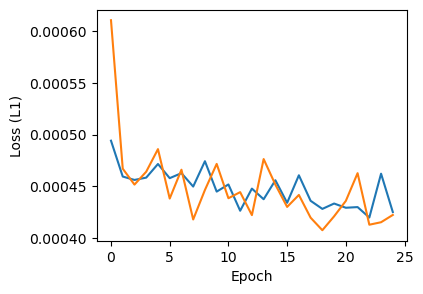

In [17]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss)
plt.plot(x,train_loss)
plt.ylabel('Loss (L1)')
plt.xlabel('Epoch')

In [ ]:
#Load in the model
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path=model_path,
    device='cpu',
)


#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=None, fg_path=configs['test_folder'], num_mixtures=999999, coherent_prob=1.0, duration=5)
item = test_data[1]
separator.audio_signal = item['mix']
estimates = separator()
estimates.append(item['mix'] - estimates[0])

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


In [ ]:
viz.show_sources(estimates)

In [ ]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
test_dataset = nussl.datasets.MUSDB18(subsets=['test'], transform=tfm)

# Just do 5 items for speed. Change to 50 for actual experiment.
for i in range(5):
    item = test_dataset[i]
    separator.audio_signal = item['mix']
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'bass+drums+other': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()

In [ ]:
scores